**TRamWAy** - <u>T</u>he <u>Ra</u>ndo<u>m</u> <u>W</u>alk <u>A</u>nal<u>y</u>zer - features tools for processing single-molecule localization microscopy data.

This notebook introduces the [RWAnalyzer](https://tramway.readthedocs.io/en/master/tramway.analyzer.html#tramway.analyzer.RWAnalyzer) object and its main functionalities, as of version *0.5*.

#### Table of contents
* [Parameter maps](#Parameter-maps)
* [SPT analysis and data structures](#SPT-analysis-and-data-structures)
* [Locations, trajectories and translocations](#Locations,-trajectories-and-translocations)
* [ROI definition](#ROI-definition)
* [Tessellation](#Tessellation), [time segmentation](#Time-segmentation) and [sampling](#Sampling)
* [Parameter estimation](#Parameter-estimation)
    * [DV inference](#DV-inference)
    * [Custom mappers](#Custom-mappers)
    * [Analyzing trajectories](#Analyzing-trajectories)
    * [Embarrassingly parallel mapper functions](#Embarrassingly-parallel-mapper-functions)

Let us first download the data required by this notebook:

In [1]:
from tutorial import *

download_RWAnalyzer_tour_data()

This notebook also requires some extra dependencies, including `scikit-learn` (required), `stopit` (optional) and those listed in the `roi` installation target for TRamWAy (only `polytope` is required):

In [2]:
import sys

!"{sys.executable}" -m pip install polytope cvxopt stopit scikit-learn

This notebook introduces (again) some basic concepts of the TRamWAy approach.

Some of the models inherited from InferenceMAP are used to estimate parameters of the dynamics of the fluorescent particles in the imaged biological sample. Such models focus on resolving the dynamics in space (and time), and are fed with individual displacements instead of entire trajectories.

Nevertheless, TRamWAy also features tools for extracting and quantifying trajectories, and two sections are dedicated to this topic.

Back to the mere TRamWAy approach that consists of resolving the dynamics in space, let us first have a look to example parameter maps.

# Parameter maps
A key product TRamWAy generates out of single particle tracking data is a collection of parameter maps that quantify the local dynamics of the observed molecules and their environment.

Let us load a data file and visualize one such map before we dive into the details of getting these parameters:

In [3]:
from tramway.analyzer import *

a              = RWAnalyzer()

In [4]:
a.spt_data.from_rwa_file('data-examples/demo1.rwa')

A *.rwa* file also stores the result of analyses on these data.

For example this file contains effective potential maps. Let us visualize them:

In [5]:
# retrieve parameter maps
sampling_label = 'gwr + 60s windowing'
sampling       = a.spt_data.get_sampling(sampling_label)
map_label      = 'dv d=50 v=2 (ns)'
maps           = sampling.get_child(map_label)

In [6]:
# reload the time segmentation used to generate the maps
a.time.from_sampling(sampling)

In [7]:
%%capture
# initialize the movie for a parameter map
import matplotlib.pyplot as plt

fig, ax        = plt.subplots(figsize=(8,7))

movie          = a.mapper.mpl.animate(fig, maps, feature='potential',
                    axes=ax, unit='std', overlay_locations=True)

In [8]:
# render the movie
from IPython.display import HTML

HTML(movie.to_jshtml())

# SPT analysis and data structures
Let us rewind and go step by step.

First, we initialized an [RWAnalyzer](https://tramway.readthedocs.io/en/master/tramway.analyzer.html#tramway.analyzer.RWAnalyzer) object.

In [9]:
from tramway.analyzer import *

a = RWAnalyzer()

This object (here `a`) contains an attribute for addressing the single particle tracking data.

We initialized this attribute with a method that mutates the parent attribute itself and, in our case,
loads a *.rwa* file:

In [10]:
a.spt_data.from_rwa_file('data-examples/demo1.rwa')

For coders who prefer explicit assignment, the following alternative syntax is allowed:

    a.spt_data = spt_data.from_rwa_file('data-examples/demo1.rwa')

A *.rwa* file stores SPT data, together with results of the analyses performed on these data.
The analysis results are organized in a tree:

In [11]:
from tutorial import *

print_analysis_tree(a.spt_data.analyses, annotations=True)
# `print(a.spt_data.analyses)` works similarly

<class 'pandas.core.frame.DataFrame'>                              		<- original SPT data
	'gwr + 60s windowing' <class 'tramway.tessellation.base.Partition'>	<- data sampling
		'dv d=50 v=2 (ns)' <class 'tramway.inference.base.Maps'>	<- parameter maps


Here the tree features a single path, with the original data available at the top node:

In [12]:
a.spt_data.dataframe # or, equivalently, `a.spt_data.analyses.data`

n        x       y       t      dx      dy    dt
0         3  41.0294  7.0758   20.48  0.0453  0.1043  0.04
1         4  41.0882  7.0933   30.16 -0.0659  0.0746  0.04
2         5  41.0113  7.0608   30.36  0.0855  0.0980  0.04
3         6  41.0608  7.1048   30.60  0.0104  0.1294  0.04
4         7  41.0816  7.0902   30.68 -0.0945  0.0432  0.04
...     ...      ...     ...     ...     ...     ...   ...
12092  1856  41.0789  6.6456  794.88 -0.0431  0.0354  0.04
12093  1856  41.0358  6.6810  794.92  0.0290 -0.0924  0.04
12094  1856  41.0648  6.5886  794.96 -0.0611  0.0485  0.04
12095  1856  41.0037  6.6371  795.00  0.0998 -0.0704  0.04
12096  1856  41.1035  6.5667  795.04 -0.0335  0.0785  0.04

[12097 rows x 7 columns]

The `x` and `y` columns represent space coordinates, `t` represents time, `n` is the trajectory index, and the other columns are displacement information that are not always present at this level.

The above analysis tree exhibits a single sampling of these data and a single set of parameter maps inferred from the so-sampled data. There could be multiple samplings of the initial trajectory data, and multiple sets of parameter maps for each sampling. A label helps identify each processing step.

In the RWAnalyzer object, in addition to the above dataframe, the `spt_data` attribute stores more information such as `frame_interval` and `localization_error`.
If this information was not automatically loaded from the file, we would set:

In [13]:
a.spt_data.frame_interval         = 0.04 # in seconds
a.spt_data.localization_precision = 0.02 # in micrometers

The second level in the tree represents the data segmentation:

In [14]:
sampling_label = 'gwr + 60s windowing'
sampling       = a.spt_data.get_sampling(sampling_label)

# `sampling.data` is `a.spt_data.analyses[sampling_label].data`

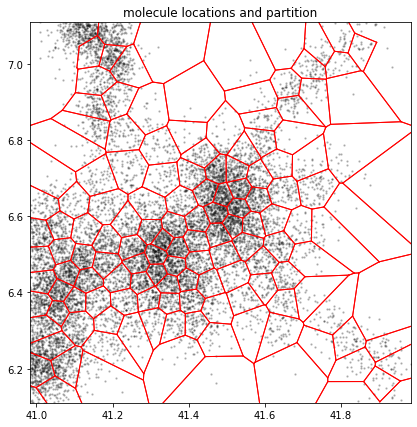

In [15]:
import matplotlib.pyplot as plt

fig, ax        = plt.subplots(figsize=(7,7))

ax.set_title('molecule locations and partition')

a.tesseller.mpl.plot(sampling, axes=ax)

The above plot shows the location data and the spatial segmentation.
In addition, the tessellation was combined with a time window, and the translocations were eventually assigned to the resulting spatio-temporal microdomains with extra constraints on the number of points per microdomain.

All this process is split in the *tessellation*, *time segmentation* and *sampling* of the data, and each step is controlled by a specific analyzer attribute.

The resulting data sampling found in the *demo1.rwa* file was obtained with the following parameters:

In [16]:
a.tesseller            = tessellers.GWR
a.tesseller.resolution = .1

a.time.from_sliding_window(duration=60, shift=30)

a.sampler.from_nearest_neighbors(20)

The third level of the analysis tree stores maps of dynamics parameters resolved in space and time:

In [17]:
# retrieve parameter maps
map_label = 'dv d=50 v=2 (ns)'
maps      = sampling.get_child(map_label)

# `maps.data` is `a.spt_data.analyses[sampling_label][map_label].data`

The above movie shows the time-varying diffusivity, which quantifies the random component in the local dynamics.

More inferred parameters are available in the `maps` object.
They are referred to as *features*, which names are explicitly listed in the object:

In [18]:
print(maps.data)

mode:                     stochastic.dv
diffusivity_prior:        50
potential_prior:          2
jeffreys_prior:           True
runtime:                  24088.606165647507
V0:                       0
allow_negative_potential: True
sigma:                    0.02
stochastic:               False
features:                 ['diffusivity', 'potential', 'force']
maps:                     <class 'pandas.core.frame.DataFrame'>


As an example, we can generate a movie for another feature, say the effective potential:

In [19]:
%%capture
# initialize the movie for a parameter map
import matplotlib.pyplot as plt

fig, ax   = plt.subplots(figsize=(8,7))

movie     = a.mapper.mpl.animate(fig, maps, feature='diffusivity',
                axes=ax, unit='std', overlay_locations=True, logscale=True)

In [20]:
# render the movie
from IPython.display import HTML

HTML(movie.to_jshtml())

These maps were obtained in a single inference with the following parameters:

In [21]:
a.mapper.from_plugin('stochastic.dv')
a.mapper.stochastic               = False # behaves like the 'dv' plugin, with more options
a.mapper.diffusivity_prior        = 50
a.mapper.potential_prior          = 2
a.mapper.jeffreys_prior           = True
a.mapper.V0                       = 0     # flat initial potential
a.mapper.allow_negative_potential = True

... and code:

In [22]:
def sample_and_infer(self):
    """ `self` is the `RWAnalyzer` object """
    
    for f in self.spt_data: # for each SPT data file (this also works with a single file)
        
        # if not already loaded, the file is actually loaded at this point
        sptdata  = f.dataframe
        
        # keep only the molecules that move by more than the localization error
        sptdata  = f.discard_static_trajectories(sptdata)
        
        # apply the `tesseller.tessellate`, `time.segment` and `sampler.sample` steps all at once
        sampling = self.sampler.sample(sptdata)
        
        # parameter inference takes time...
        maps     = self.mapper.infer(sampling)
        
        # wrap the original `sampling` and `maps` objects in node-like objects;
        # this stores the analysis artefacts in the analysis tree for `f`
        sampling = commit_as_analysis(sampling_label, sampling, parent=f)
        maps     = commit_as_analysis(map_label, maps, parent=sampling)
        
        # save to file;
        # in most cases, it is preferable to let the RWAnalyzer automatically determine the output filepath
        f.analyses.save()
        

Here, `sampler.sample` calls the `tessellate` and `segment` methods of the `tesseller` and `time` attributes respectively. Of note, the `sampler` attribute would exhibit a working `sample` method even if not initialized.

At this point, `sample_and_infer` can run as-is:

```
sample_and_infer(a)
```

The code in the body of the function could run without making it a function,
but we do not want it to run now, as the `infer` step may take a few hours to complete.

As a function, the execution of `sample_and_infer` is also ready to be parallelized using the [pipeline capability](RWAnalyzer%20simple%20pipeline.ipynb) of [RWAnalyzer](https://tramway.readthedocs.io/en/master/tramway.analyzer.html#tramway.analyzer.RWAnalyzer).
For example, with a few additional lines of code, `sample_and_infer` execution can be delegated to a computer cluster and the resulting output file(s) retrieved onto the host that runs the Jupyter notebook.

### Summary
Before any analysis is run and an output *.rwa* file is generated, the SPT data often come as a text file.

To sum up, and as a transition to the next section, let us export the SPT data to an ascii file and start from scratch without printing or plotting anything:

In [23]:
a.spt_data.to_ascii_file('data-examples/demo1.txt')

In [24]:
from tramway.analyzer import *

a = RWAnalyzer()

Note the main difference:

In [25]:
a.spt_data.from_ascii_file('data-examples/demo1.txt')

In [26]:
a.spt_data.frame_interval         = 0.04 # in seconds
a.spt_data.localization_precision = 0.02 # in micrometers

a.tesseller                       = tessellers.GWR
a.tesseller.resolution            = .1

a.time.from_sliding_window(duration=60, shift=30)

a.sampler.from_nearest_neighbors(20)

a.mapper.from_plugin('stochastic.dv')
a.mapper.stochastic               = False # behaves like the 'dv' plugin, with more options
a.mapper.diffusivity_prior        = 50
a.mapper.potential_prior          = 2
a.mapper.jeffreys_prior           = True
a.mapper.V0                       = 0     # flat initial potential
a.mapper.allow_negative_potential = True

... and we are ready!

In [27]:
# sample_and_infer(a)

Note that, if you want to adapt `sampling_label` and `map_label`, you will have to redefine `sample_and_infer`.

# Locations, trajectories and translocations
Location and displacement information is made available in `pandas.DataFrame`s. However, there are subtle differences between trajectories and translocations.

Let us load some localization data:

In [28]:
from tramway.core import load_xyt

locations = load_xyt('data-examples/c05_low_density.tsf.xyt', columns=list('xyt'))
locations

x        y      t
0      26.6615  39.5796   0.06
1      26.1820  43.4160   0.06
2      27.0411  26.9305   0.06
3      29.1381  48.5524   0.06
4      30.5583  21.6255   0.06
...        ...      ...    ...
33546  55.6979  43.6495  31.20
33547  55.8001  45.0347  31.20
33548  59.9244  36.4617  31.20
33549  58.5234  29.2296  31.20
33550  58.7866  36.8735  31.20

[33551 rows x 3 columns]

The `x` and `y` columns represent space, in $\mu m$, and `t` represents time, in $s$.

The frame interval appears to be 0.06 and, as can be seen above in the dataframe, the locations are ordered in time.

The `tramway.core` module exports convenience functions like `iter_frames` to loop over the locations grouped by frame.

## Localization data tracking
Let us track these data using the *non-tracking* tracker:

In [29]:
from tramway.analyzer import *

a                                    = RWAnalyzer()
a.tracker.from_non_tracking()
a.tracker.frame_interval             = 0.06

This algorithm requires some hint about the values expected for diffusivity, plus an indication about the localization precision or error:

In [30]:
a.tracker.estimated_high_diffusivity = 0.3
a.tracker.localization_precision     = 0.03

### Side note
Some key parameters such as `frame_interval` and `localization_precision` are available at multiple places.
These parameters are actually stored in the `spt_data` attribute:

In [31]:
a.spt_data.frame_interval

0.06

This has been made possible by the `tracker` attribute altering the `spt_data` attribute:

In [32]:
a.spt_data

... while it was beforehands:

In [33]:
RWAnalyzer().spt_data

## Tracking (continued)

In [34]:
a.tracker.track(locations, register=True)

n        x        y      t
0         1  26.1820  43.4160   0.06
1         1  26.2917  43.2076   0.12
2         2  27.0411  26.9305   0.06
3         2  27.3263  26.7477   0.12
4         3  22.3443  46.9515   0.06
...     ...      ...      ...    ...
12850  5097  59.7249  40.3669  31.20
12851  5098  47.0593  36.7691  31.14
12852  5098  47.3644  36.9945  31.20
12853  5099  36.9425  36.9245  31.14
12854  5099  36.7721  37.0181  31.20

[12855 rows x 4 columns]

The `track` method applied to the example localization file returned a `pandas.DataFrame` that represents the resulting trajectories.
Column `n` encodes the trajectory index.
Rows are locations, ordered first by trajectory index and second by time.

The `register=True` option made `track` append the series of trajectories to the `spt_data` attribute:

In [35]:
for f in a.spt_data:
    pass
f.dataframe

n        x        y      t
0         1  26.1820  43.4160   0.06
1         1  26.2917  43.2076   0.12
2         2  27.0411  26.9305   0.06
3         2  27.3263  26.7477   0.12
4         3  22.3443  46.9515   0.06
...     ...      ...      ...    ...
12850  5097  59.7249  40.3669  31.20
12851  5098  47.0593  36.7691  31.14
12852  5098  47.3644  36.9945  31.20
12853  5099  36.9425  36.9245  31.14
12854  5099  36.7721  37.0181  31.20

[12855 rows x 4 columns]

Note here that we had to loop over items in `a.spt_data`.
Indeed, the `track` method can be called multiple times, on different files, and consequently the `spt_data` attribute could contain multiple items.

Because these *data provider* attributes (others are `images` and `roi`) are always iterable and often contain a single item, the `tramway.analyzer` package exports some very simple convenience functions to get the first or unique item of such iterators:

In [36]:
trajectories = single(a.spt_data).dataframe
trajectories

n        x        y      t
0         1  26.1820  43.4160   0.06
1         1  26.2917  43.2076   0.12
2         2  27.0411  26.9305   0.06
3         2  27.3263  26.7477   0.12
4         3  22.3443  46.9515   0.06
...     ...      ...      ...    ...
12850  5097  59.7249  40.3669  31.20
12851  5098  47.0593  36.7691  31.14
12852  5098  47.3644  36.9945  31.20
12853  5099  36.9425  36.9245  31.14
12854  5099  36.7721  37.0181  31.20

[12855 rows x 4 columns]

We can now run the same type of analyses on the SPT data, as presented before.

## Representations for trajectories and translocations
The models underlying the main inference methods available in TRamWAy do not need entire trajectories, but only individual displacements, or translocations.

To make the notion of translocation visible, let us define a region of interest and crop the data within this ROI:

In [37]:
a.spt_data.bounds

n        x        y      t
min     1.0  19.8098  19.2550   0.06
max  5099.0  61.5214  58.6531  31.20

In [38]:
from tramway.core import crop

cropped_trajectories = crop(trajectories, [20.,20.,10.,10.], keep_nan=True)
cropped_trajectories

n        x        y      t      dx      dy    dt
0    3  27.0411  26.9305   0.06  0.2852 -0.1828  0.06
1    3  27.3263  26.7477   0.12     NaN     NaN   NaN
2    4  27.2278  26.7087   0.24  0.1957 -0.1466  0.06
3    4  27.4235  26.5621   0.30     NaN     NaN   NaN
4    5  25.1026  29.9191   1.32     NaN     NaN   NaN
..  ..      ...      ...    ...     ...     ...   ...
94  46  24.5733  25.5749  28.68     NaN     NaN   NaN
95  47  27.0603  28.2362  29.34 -0.0411  0.2687  0.06
96  47  27.0192  28.5049  29.40     NaN     NaN   NaN
97  48  22.5607  28.6995  30.12  0.0184  0.0718  0.06
98  48  22.5791  28.7713  30.18     NaN     NaN   NaN

[99 rows x 7 columns]

We took a (huge) 10x10$\mu m$ area and found a hundred locations in it (these data are indeed low-density, as the filename stated).

*delta* columns were added: `dx`, `dy` and `dt`.
They encode the displacement from the location described in the same row.

The terminal location for each trajectory exhibits undefined *delta* values (NaN).
As such, the above data are still considered as trajectory data.

Translocations are the rows with defined displacement information:

In [39]:
translocations = crop(trajectories, [20.,20.,10.,10.])
translocations

n        x        y      t      dx      dy    dt
0    3  27.0411  26.9305   0.06  0.2852 -0.1828  0.06
1    4  27.2278  26.7087   0.24  0.1957 -0.1466  0.06
2    6  25.1349  23.8702   1.56  0.1845  0.0494  0.06
3    7  24.7621  27.4019   1.62 -0.1749  0.1544  0.06
4    8  23.1742  29.7438   1.92  0.1180  0.0517  0.06
5    9  28.7786  24.6987   1.92  0.2697 -0.0591  0.06
6   11  23.3951  26.1521   2.40 -0.0637  0.0210  0.06
7   12  24.3211  28.6779   2.94  0.1078 -0.0966  0.06
8   13  23.8051  25.8957   3.06 -0.0228 -0.0425  0.06
9   14  23.5812  26.1698   3.48  0.0822  0.0590  0.06
10  15  25.8738  25.7641   3.66  0.0967  0.0583  0.06
11  16  25.5192  28.2850   4.02  0.0732 -0.0069  0.06
12  16  25.5924  28.2781   4.08  0.1413 -0.1463  0.06
13  17  25.8584  29.7977   4.80  0.1558  0.0857  0.06
14  18  28.7501  24.9676   4.80 -0.0514 -0.1258  0.06
15  19  28.3569  24.3927   4.98  0.1267 -0.2175  0.06
16  20  23.0978  26.6031   5.16  0.0110  0.1074  0.06
17  20  23.1088  26.7105   5.22  0.0810  0.0123  0.06
18  21  28.7045  24.0288   5.22 -0.2425 -0.0903  0.06
19  21  28.4620  23.9385   5.28  0.1078  0.1141  0.06
20  22  22.2845  29.7189   6.90 -0.0262 -0.1684  0.06
21  23  23.0325  27.7425   7.68 -0.1857  0.1743  0.06
22  24  26.9606  29.8861   7.74 -0.3520 -0.1299  0.06
23  24  26.6086  29.7562   7.80 -0.1021 -0.2357  0.06
24  25  29.3890  22.1387   8.16  0.0584  0.0700  0.06
25  26  26.4867  25.3496   8.46 -0.0874 -0.0899  0.06
26  27  27.5846  24.0548   9.48 -0.3406  0.1331  0.06
27  28  28.7021  21.1412   9.72  0.2424 -0.0729  0.06
28  29  23.5506  26.5477  10.08  0.1035 -0.0533  0.06
29  30  27.3245  26.7311  10.44  0.1943 -0.2405  0.06
30  30  27.5188  26.4906  10.50 -0.0489 -0.0745  0.06
31  31  22.8085  29.1061  10.68  0.0706 -0.1762  0.06
32  32  22.7433  28.1974  13.32 -0.1612 -0.0171  0.06
33  33  23.1388  26.7523  13.32 -0.0638 -0.0939  0.06
34  34  23.2600  26.7885  13.56 -0.1208  0.1310  0.06
35  35  23.4722  26.7546  13.74  0.0238 -0.0054  0.06
36  36  23.0787  27.4579  13.92 -0.0417 -0.2430  0.06
37  36  23.0370  27.2149  13.98 -0.1170  0.1601  0.06
38  37  29.3023  20.5713  16.20 -0.1950  0.1399  0.06
39  38  23.1069  29.9647  16.74  0.0198 -0.3451  0.06
40  39  22.5807  29.9396  18.06  0.0585 -0.0822  0.06
41  39  22.6392  29.8574  18.12  0.3057 -0.1412  0.06
42  40  24.9568  28.7359  19.32 -0.0768  0.0919  0.06
43  41  23.9873  26.3748  19.62  0.1324 -0.1729  0.06
44  42  25.0780  29.0597  19.68  0.1884 -0.2461  0.06
45  43  23.3956  29.0623  20.04 -0.2612 -0.2665  0.06
46  45  23.6875  29.2673  23.10  0.0428 -0.0589  0.06
47  46  24.4823  25.4458  28.44  0.0508 -0.0558  0.06
48  46  24.5331  25.3900  28.50 -0.0202  0.1878  0.06
49  46  24.5129  25.5778  28.56 -0.0652 -0.0410  0.06
50  46  24.4477  25.5368  28.62  0.1256  0.0381  0.06
51  47  27.0603  28.2362  29.34 -0.0411  0.2687  0.06
52  48  22.5607  28.6995  30.12  0.0184  0.0718  0.06

Some methods, <i>e.g.</i> for plotting trajectories, explicitly require trajectory data, while other methods require translocations only.

The `tramway.core` package exports conversion functions such as `trajectories_to_translocations` and `translocations_to_trajectories`.
This package also exports the `iter_frames` and `iter_trajectories` functions to iterate such dataframes over groups of rows.

# ROI definition
The above cropping can be generalized to many regions of interest using the `roi` attribute.
Regions of interest can be defined in many ways, as square areas centered at <i>e.g.</i> density peaks, or bounding boxes on the coordinates, including time, etc.


In [40]:
from tramway.analyzer import *

a                                    = RWAnalyzer()
a.tracker.from_non_tracking()
a.tracker.frame_interval             = 0.06
a.tracker.estimated_high_diffusivity = 0.3
a.tracker.localization_precision     = 0.03

In [41]:
from tramway.core import load_xyt

for source in (
        'data-examples/Manip01-01-Beta400AA-01-15ms.rpt.xyt',
        'data-examples/Manip01-01-Beta400AA-02-15ms.rpt.xyt'):
    
    xyt         = load_xyt(source, columns=['x', 'y', 'frame index'])
    
    xyt['t']    = xyt['frame index'] * a.tracker.frame_interval
    
    a.tracker.track(xyt, source=source, register=True)

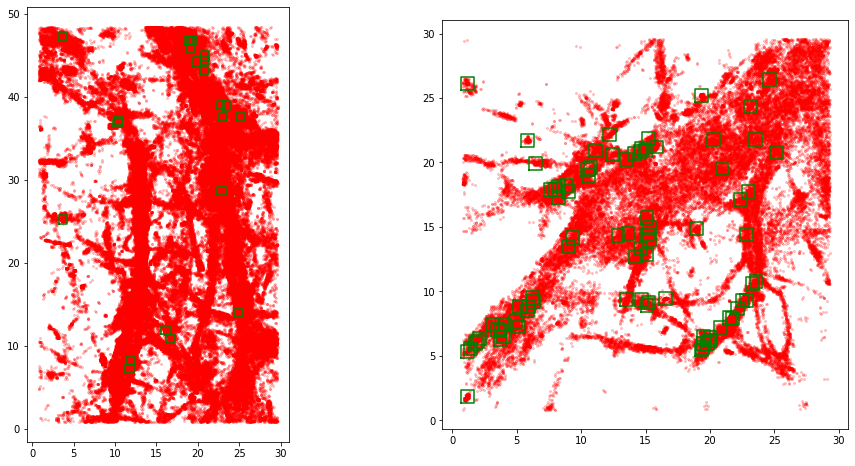

In [42]:
from tramway.analyzer.roi.utils import *
import matplotlib.pyplot as plt

roi_size        = 1.

_, axes         = plt.subplots(1, len(a.spt_data), figsize=(16,8))

for f, ax in zip(a.spt_data, axes):
    # identify density peaks
    roi_centers = density_based_roi(f.dataframe, .0075)
    
    # define square ROI centered on the peaks
    f.roi.from_squares(roi_centers, roi_size)
    
    # plot the data
    f.mpl.plot(axes=ax)

As of version *0.5*, the encouraged way to store such ROI center or boundary information is additional text files similar to SPT ascii files, with similar filenames as well, using a suffix before the extension to differenciate between SPT and ROI files.

In [43]:
import numpy as np
import pandas as pd
import os

for f in a.spt_data:
    basename, _ = os.path.splitext(f.source)
    
    f.to_ascii_file(basename+'.txt')
    
    f.roi.to_ascii_file(basename+'-roi.txt')
    

Let us simply print the number of translocations per ROI:

In [44]:
a = RWAnalyzer()

a.spt_data.from_ascii_files('data-examples/Manip01-01-Beta400AA-*-15ms.rpt.txt')

a.roi.from_ascii_files(suffix='-roi') # '-roi' is the default suffix and can be omitted

for r in a.roi.as_support_regions():
    # get the translocations that originate from within the roi bounding box
    sptdata     = r.crop()
    
    # the `source` attribute points to the spt data source;
    # the `label` attribute is the default label for any sampling of the ROI data
    print(r.source, r.label, len(sptdata), sep='\t')

data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi000	464
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi001	671
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi002	817
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi003	612
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi004	457
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi005	868
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi006	727
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi007	3513
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi008	902
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi009	764
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi010	1004
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi011	884
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi012	701
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi013	957
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi014	1041
data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt	roi015	902
data-

## Strategies for overlapping ROI

Regions of interest may exhibit some overlap, which is to be expected when they are automatically identified.
In the case of overlapping ROI, it usually makes sense to group these regions before segmenting the data and inferring model parameters.

Initializer methods for the `roi` attribute feature an optional `group_overlapping_roi` argument that can be set to `True`.
This combines the input ROI into so-called *support regions* for data processing, while the original ROI, termed *individual roi*, operate as windows on the corresponding support region.

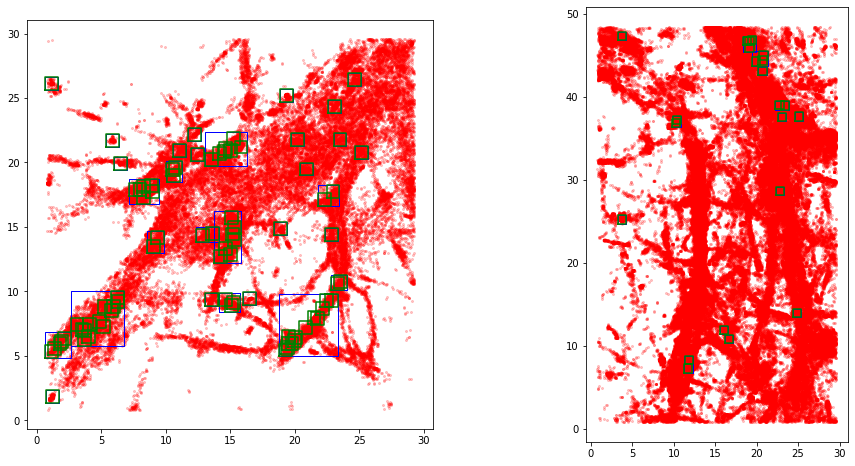

In [45]:
a = RWAnalyzer()

a.spt_data.from_ascii_files('data-examples/Manip01-01-Beta400AA-*-15ms.rpt.txt')

a.roi.from_ascii_files(suffix='roi', group_overlapping_roi=True)

_, axes         = plt.subplots(1, len(a.spt_data), figsize=(16,8))

for f, ax in zip(a.spt_data, axes):
    f.mpl.plot(axes=ax, sup_color='blue')

In the above figures, the blue rectangles depict the rectangular bounding box of support regions,
whereas support regions are not necessarily rectangles.
Indeed, a support region is a union of ROI, no more.

As a consequence, the `roi` attribute can be iterated in two ways.
One can loop over either the individual ROI or the support regions, with the `as_individual_roi` or `as_support_regions` methods respectively.
Choosing what to iterate is made a requirement, and the `roi` attribute itself cannot be iterated as is.

Even if no grouping is performed (default behavior), `as_support_regions` should be used instead of `as_individual_roi` for data processing, including segmentation and standard inference,
especially as `as_individual_roi` is not supported yet by some flavors of [parallel processing](RWAnalyzer%20simple%20pipeline.ipynb), and an exception may be raised at the time of dispatching tasks with ROI granularity.

For post-mapping analysis, the support regions can be accessed from the individual ROI, but only when `as_individual_roi` is called from an SPT data item (`f.roi` and not `a.roi`):

In [46]:
n = 0

for f in a.spt_data:
    for roi_index, roi_obj in f.roi.as_individual_roi(return_index=True):
        
        if 20 < n:
            break
        n += 1
        
        support_region = f.roi.get_support_region(roi_index)
        
        print(f'{roi_obj.label} lies in support region:\t{support_region.label}')
        
print('...')

roi000 lies in support region:	roi000-003-004-005-006
roi001 lies in support region:	roi001
roi002 lies in support region:	roi002
roi003 lies in support region:	roi000-003-004-005-006
roi004 lies in support region:	roi000-003-004-005-006
roi005 lies in support region:	roi000-003-004-005-006
roi006 lies in support region:	roi000-003-004-005-006
roi007 lies in support region:	roi007-008-009-010-011-012-013-014-015-016-018-019-020
roi008 lies in support region:	roi007-008-009-010-011-012-013-014-015-016-018-019-020
roi009 lies in support region:	roi007-008-009-010-011-012-013-014-015-016-018-019-020
roi010 lies in support region:	roi007-008-009-010-011-012-013-014-015-016-018-019-020
roi011 lies in support region:	roi007-008-009-010-011-012-013-014-015-016-018-019-020
roi012 lies in support region:	roi007-008-009-010-011-012-013-014-015-016-018-019-020
roi013 lies in support region:	roi007-008-009-010-011-012-013-014-015-016-018-019-020
roi014 lies in support region:	roi007-008-009-010-01

The connection between a ROI and the corresponding support region is not made easier than demonstrated above, because ROI can also be defined in multiple collections, with different labels (instead of the simple 'roi' label), possibly corresponding to different experimental conditions to be compared, while still having support regions that can group ROI from different collections.

# Tessellation

To resolve the dynamics in space, TRamWAy offers several approaches for segmenting the space. These segmentation approaches all consist of partitioning the space into cells. They offer a basis for sampling the data into microdomains that may overlap as explained in the [sampling](#Sampling) section.

One of the most basic spatial segmentation approaches draws hexagonal tiles:

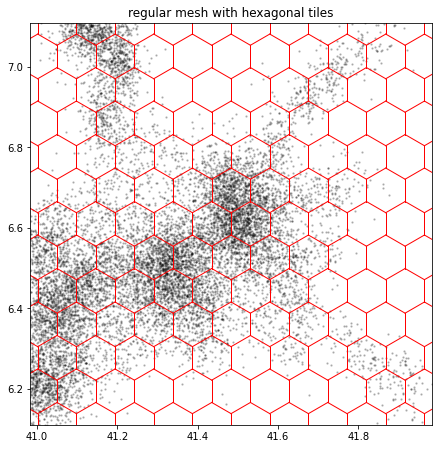

In [47]:
from tramway.analyzer import *
import matplotlib.pyplot as plt

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02
a.spt_data.frame_interval         = 0.04

a.tesseller                       = tessellers.Hexagons

as_                               = a.sampler.sample(a.spt_data.dataframe)

fig, ax                           = plt.subplots(1,1, figsize=(7.2,8))
a.tesseller.mpl.plot(as_, axes=ax, title='regular mesh with hexagonal tiles')

Another method, that adapts to the local density or local displacement length, is based on the Growing-When-Required self-organizing graph technique:

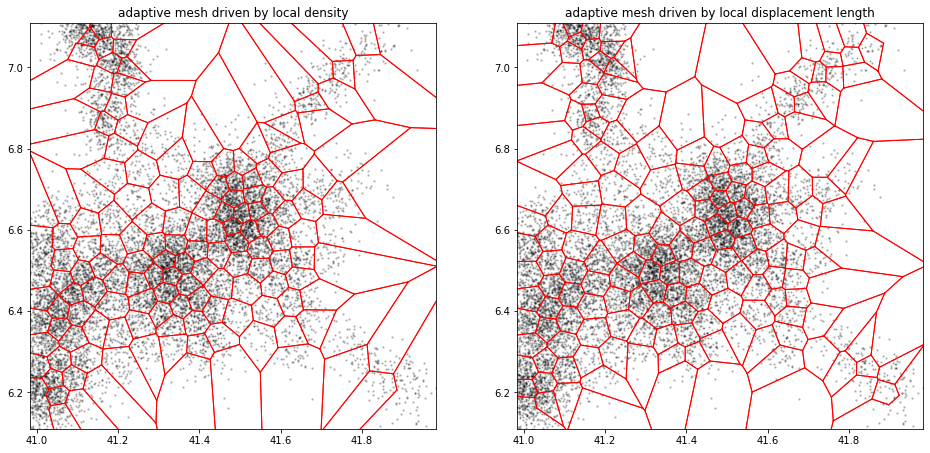

In [48]:
b                                 = RWAnalyzer()
b.tesseller                       = tessellers.GWR
b.tesseller.topology              = 'approximate density'
b.tesseller.resolution            = 0.1

c                                 = RWAnalyzer()
c.tesseller                       = tessellers.GWR
c.tesseller.topology              = 'displacement length'
c.tesseller.resolution            = 0.1


np.random.seed(23794837)
bs                                = b.sampler.sample(a.spt_data.dataframe)

np.random.seed(23794837)
cs                                = c.sampler.sample(a.spt_data.dataframe)
    
_, ax                             = plt.subplots(1,2, figsize=(16,8))
b.tesseller.mpl.plot(bs, axes=ax[0], title='adaptive mesh driven by local density')
c.tesseller.mpl.plot(cs, axes=ax[1], title='adaptive mesh driven by local displacement length')

Each tessellation approach offers specific parameters in addition to the general `resolution` parameter that is differently interpreted by the different approaches.

Most methods are referenced in the [documentation](https://tramway.readthedocs.io/en/latest/tessellation.html#standard-methods) and RWAnalyzer-adapted wrappers are featured by the `tessellers` module object for some of the available methods.

## Side effects

Note that we initialized multiple RWAnalyzer objects to process the data from only one analyzer object.

Generally this is not recommended.
The attributes that represent specific processing steps may access other attributes to gather all the necessary information.
As a consequence, side effects are to be expected.

![Class diagram](http://yuml.me/flaurent/rwanalyzer-and-representation-attributes.png)

Almost all the attributes access general parameters such as `frame_interval` and `localization_error` that are stored in the `spt_data` attribute.

Other dependencies exist in the `sampler` attribute that accesses the `tesseller` and `time` attributes, and in the `mapper` attribute that also accesses the `time` attribute.

## More about side effects

To prevent reusing analyzer objects, which may cause side effects, assigning a new value to an initialized attribute is not allowed:

In [49]:
%%script python3 --no-raise-error

from tramway.analyzer import *

a              = RWAnalyzer()
a.spt_data     = spt_data.from_ascii_file('data-examples/demo1.txt')

df             = a.spt_data.dataframe

# not allowed!
a.spt_data     = spt_data.from_dataframe(df)

Traceback (most recent call last):
  File "<stdin>", line 10, in <module>
  File "/home/flaurent/github/TRamWAy/tramway/analyzer/__init__.py", line 466, in __setattr__
    warnings.warn(


To allow attribute overwrite, and show an example side effect:

In [50]:
import warnings
warnings.simplefilter('ignore', SideEffectWarning)

a                                 = RWAnalyzer()

a.spt_data                        = spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.03

a.time.frame_interval             = 0.05  # this actually sets `frame_interval` in `spt_data`

former_spt_data                   = a.spt_data

a.spt_data                        = spt_data.from_dataframe(former_spt_data.dataframe)
a.spt_data.localization_error     = former_spt_data.localization_error
a.spt_data.dt                     = former_spt_data.dt # `dt` is an alias for `frame_interval`

dict(
    localization_precision        = a.spt_data.localization_precision,
    frame_interval                = a.spt_data.frame_interval        )

{'localization_precision': 0.03, 'frame_interval': 0.05}

Some overwritting use cases are allowed through specific methods such as [reload_from_rwa_files](https://tramway.readthedocs.io/en/master/tramway.analyzer.html#tramway.analyzer.spt_data.SPTDataIterator.reload_from_rwa_files) that can be called when SPT data are processed from ascii files on a remote host, and retrieved as *.rwa* files onto the local host, to reload the resulting analysis trees from these *.rwa* files corresponding to the input ascii files.

## Other methods

Some tessellation methods such as InferenceMAP's quadtree, called *kdtree* in TRamWAy, are not available as dedicated wrappers.
They can be loaded as plugins:

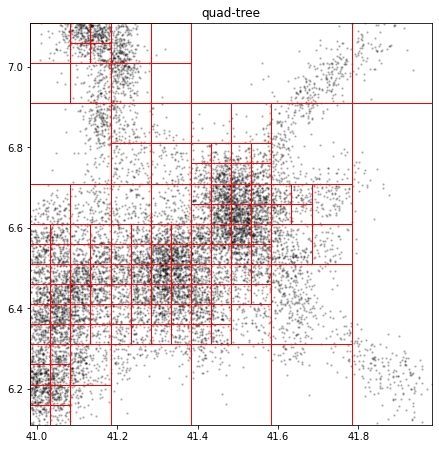

In [51]:
d                                 = RWAnalyzer()

d.tesseller.from_plugin('kdtree')
d.tesseller.resolution            = 0.05

ds                                = d.sampler.sample(a.spt_data.dataframe)

_, ax                             = plt.subplots(1,1, figsize=(7.2,8))
d.tesseller.mpl.plot(ds, axes=ax, title='quad-tree')

# Time segmentation

In addition to tessellating the space, the data can also be segmented into time segments, often using a sliding window:

In [52]:
from tramway.analyzer import *
import matplotlib.pyplot as plt

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02
a.spt_data.frame_interval         = 0.04

a.tesseller                       = tessellers.Hexagons

In [53]:
a.time.from_sliding_window(60)          # window duration in seconds
a.time.window_shift               = 45  # in seconds; this introduces a 25%-overlap between successive segments (default is no overlap)

In [54]:
sampling                          = a.sampler.sample(a.spt_data.dataframe)

One can iterate over the resulting time segments, as the following example that prints the number of translocations assigned to each segment:

In [55]:
for times, individual_segment_sampling in a.time.as_time_segments(sampling, return_times=True):
    print(
        a.time.segment_label(None, times, sampling),
        len(individual_segment_sampling.points),
        sep=': \t',
    )

t=20.48-80.48s: 	186
t=65.48-125.48s: 	730
t=110.48-170.48s: 	1048
t=155.48-215.48s: 	1339
t=200.48-260.48s: 	1365
t=245.48-305.48s: 	1142
t=290.48-350.48s: 	933
t=335.48-395.48s: 	981
t=380.48-440.48s: 	750
t=425.48-485.48s: 	526
t=470.48-530.48s: 	826
t=515.48-575.48s: 	1250
t=560.48-620.48s: 	1119
t=605.48-665.48s: 	1100
t=650.48-710.48s: 	964
t=695.48-755.48s: 	975
t=740.48-800.48s: 	925


A movie can be generated to visualize these points:

In [56]:
%%capture
fig, _                            = plt.subplots(figsize=(7,7))
movie                             = a.tesseller.mpl.animate(fig, sampling)

In [57]:
from IPython.display import HTML

HTML(movie.to_jshtml())

# Sampling

More importantly, these spatial and temporal segmentations are used to sample the (trans-)location data.
The default approach -- *e.g.* for space -- consists of partitioning, *i.e.* assigning to each microdomain all the points that lie within the corresponding Voronoi cell.
The Voronoi cells are illustrated as meshes in red in previous figures and movies.

However, the segmentations actually define the microdomains as center points only. The extent of the microdomains may be overriden so that a given point can be assigned to multiple microdomains, or none.

Data sampling is controlled by the `sampler` attribute.
It features several initializers, including [from_voronoi](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.SamplerInitializer.from_voronoi) (default behavior), [from_spheres](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.SamplerInitializer.from_spheres) and [from_nearest_neighbors](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.SamplerInitializer.from_nearest_neighbors) that implement different behaviors along the spatial dimensions, and [from_nearest_time_neighbors](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.SamplerInitializer.from_nearest_time_neighbors) for adapting the time window locally.

All the samplers first operate like `from_voronoi` and then perform local adjustments so as to enforce criteria such as a lower bound on the number of assigned points per microdomain.

Using alternative samplers, it is actually possible to assign data to microdomains that originally (following the default/initial behavior) do not contain any point.
This can also be controlled with an attribute common to all the samplers: [min_location_count](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.BaseSampler.min_location_count).
In the former API (the `tessellate` function), this parameter is 1 per default, while it is 0 here.

The resulting segmentations are better illustrated with a color map and, as a consequence, an example sampling is explained in further details in the next section.

# Parameter estimation

Once microdomains are defined, with their respective (trans-)location data, all sorts of estimates can be extracted in each microdomain, taken individually or altogether, using the `mapper` attribute of an `RWAnalyzer` object.

TRamWAy features several [inference procedures](https://tramway.readthedocs.io/en/latest/inference.html#concepts) for models borrowed from InferenceMAP.

## DV inference

As showed in previous sections, the [DV model](https://tramway.readthedocs.io/en/latest/inference.html#inference-dv) explains the observed displacements as resulting from a diffusive term and a drift component derived from a potential lanscape:

$\frac{d\textbf{r}}{dt} = \sqrt{2D(\textbf{r})} \xi(t) - D(\textbf{r}) \frac{\nabla V(\textbf{r})}{k_{\textrm{B}}T}$

This model jointly estimates the local diffusivities $D$ (in $\mu m^2. s^{-1}$ if coordinates $\textbf{r}$ are expressed as $\mu m$) and effective potentials $V$ (expressed as $k_{\textrm{B}}T$), and can be defined and applied in different ways:

* the *'dv'* plugin, suitable for moderate numbers of microdomains and, if a sliding window is applied to segment the data, as long as no time regularization is performed
* the *'stochastic.dv'* plugin, suitable for large inferences (many microdomains) and time-regularized inferences

The latter variant can be interrupted and/or a timeout can be defined, which makes it a better candidate for a rapid demonstration. Let us go straight to the figures, and then explain.

### Define the processing steps

In [58]:
from tramway.analyzer import *
import matplotlib.pyplot as plt

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02

a.tesseller                       = tessellers.Hexagons

a.sampler.from_nearest_neighbors(10)
a.sampler.min_location_count      = 1

In [59]:
a.mapper.from_plugin('stochastic.dv')
a.mapper.diffusivity_prior        = 20
a.mapper.potential_prior          = 1
a.mapper.max_runtime              = 20 # in seconds; note that if TRamWAy does not find the stopit package, this argument is ignored and the inference takes about 10 minutes
#a.mapper.verbose                  = False

### Process

In [60]:
# step 1. read the data
translocation_data                = a.spt_data.dataframe
# step 2. sample the data
data_sampling                     = a.sampler.sample(translocation_data)
# step 3. estimate the model parameters
inferred_parameters               = a.mapper.infer(data_sampling)

number of workers: 39
At iterate  17	f(15)= -3.307151E+02 	df= -7.222612E-01 	proj g = 1.791113E+00
At iterate  38	f(11)= -2.380497E+02 	df= -3.077709E-01 	proj g = 2.981002E-01
At iterate  10	f(109)= -2.143482E+03 	df= -7.840563E+00 	proj g = 1.231149E+01
At iterate  12	f(102)= -1.209763E+03 	df= -1.459449E+00 	proj g = 6.992921E-01
At iterate   5	f(54)= -5.308055E+02 	df= -3.436426E-01 	proj g = 6.376081E-01
At iterate  22	f(1)= -1.285399E+03 	df= -1.732360E+00 	proj g = 1.842191E+00
At iterate  16	f(5)= -2.474951E+02 	df= -4.551516E-01 	proj g = 4.799808E-01
At iterate   3	f(35)= -5.791890E+02 	df= -1.724638E+00 	proj g = 2.921333E+00
At iterate   8	f(104)= -7.484283E+02 	df= -5.181336E-01 	proj g = 1.007127E+00
At iterate  13	f(9)= -2.652009E+02 	df= -2.818644E-01 	proj g = 6.520562E-01
At iterate  36	f(2)= -6.402305E+02 	df= -4.713044E-01 	proj g = 5.392779E-01
At iterate  20	f(89)= -1.131065E+03 	df= -3.596787E+00 	proj g = 5.745741E+00
At iterate  35	f(13)= -4.389332E+02 	df= -1

At iterate 106	f(22)= -7.377785E+02 	df= -3.507047E-01 	proj g = 3.412992E-01
At iterate 105	f( 76)= -8.818033E+02 	df= -1.027107E+00 	proj g = 1.875540E+00
At iterate 109	f(88)= -9.853534E+02 	df= -4.132822E-01 	proj g = 1.034062E+00
At iterate 111	f( 46)= -2.654417E+03 	df= -1.968187E+01 	proj g = 2.555921E+01
At iterate  92	f(53)= -1.873057E+03 	df= -4.122590E+00 	proj g = 4.736464E+00
At iterate 103	f( 7)= -2.303468E+03 	df= -8.333517E+00 	proj g = 1.543903E+01
At iterate 113	f(91)= -7.194122E+02 	df= -2.198438E-01 	proj g = 1.711957E-01
At iterate 115	f(66)= -9.941566E+02 	df= -3.931026E+00 	proj g = 1.150735E+01
At iterate 117	f(111)= -3.552709E+02 	df= -9.901321E-01 	proj g = 3.888823E+00
At iterate 102	f(40)= -5.361152E+03 	df= -3.125740E+00 	proj g = 4.500777E+00
At iterate 127	f(107)= -1.370062E+02 	df= -2.152010E-03 	proj g = 4.371386E-03
At iterate 112	f( 32)= -2.086604E+03 	df= -2.528510E+00 	proj g = 3.036177E+00
At iterate 114	f(30)= -3.295306E+03 	df= -3.679469E+00 	pro

At iterate 224	f( 54)= -5.406834E+02 	df= -1.600190E+00 	proj g = 4.862242E+00
At iterate 208	f( 33)= -1.405681E+03 	df= -9.623388E-02 	proj g = 1.924604E-01
At iterate 206	f(39)= -4.760490E+03 	df= -2.157525E-02 	proj g = 3.845646E-02
At iterate 214	f(46)= -2.684132E+03 	df= -4.635961E-01 	proj g = 9.434970E-01
At iterate 227	f( 36)= -4.402857E+02 	df= -3.471607E-01 	proj g = 6.687817E-01
At iterate 207	f(85)= -1.215278E+03 	df= -4.645357E+00 	proj g = 9.761430E+00
At iterate 211	f(105)= -7.030495E+02 	df= -1.518332E-01 	proj g = 3.038709E-01
At iterate 201	f( 63)= -1.302333E+03 	df= -7.599429E-01 	proj g = 1.178005E+00
At iterate 222	f( 13)= -4.462054E+02 	df= -2.398220E-03 	proj g = 4.810323E-03
At iterate 218	f( 21)= -1.022493E+03 	df= -1.763230E-01 	proj g = 3.604644E-01
At iterate 209	f( 29)= -3.360776E+03 	df= -2.495389E+00 	proj g = 4.328638E+00
At iterate 236	f(107)= -1.370496E+02 	df= -2.317326E-02 	proj g = 7.839532E-02
At iterate 225	f( 87)= -5.799796E+02 	df= -2.725016E+00

At iterate 312	f(60)= -6.966653E+03 	df= -1.311910E-02 	proj g = 2.632031E-02
At iterate 331	f(102)= -1.249954E+03 	df= -1.743693E-01 	proj g = 4.445415E-01
At iterate 335	f( 55)= -1.040612E+03 	df= -8.603998E-01 	proj g = 6.329484E-01
At iterate 329	f(75)= -3.233131E+02 	df= -2.553952E-02 	proj g = 5.728170E-02
At iterate 309	f(14)= -5.869919E+02 	df= -9.806750E-03 	proj g = 1.826982E-02
At iterate 316	f(30)= -3.323888E+03 	df= -2.169286E-02 	proj g = 4.680899E-02
At iterate 318	f(  7)= -2.429055E+03 	df= -9.656412E-01 	proj g = 2.339979E+00
At iterate 338	f(37)= -2.260078E+03 	df= -1.136406E+00 	proj g = 1.864857E-01
At iterate 319	f( 72)= -1.913627E+03 	df= -2.073654E-03 	proj g = 4.173360E-03
At iterate 317	f( 33)= -1.405810E+03 	df= -1.609306E-03 	proj g = 3.242720E-03
At iterate 323	f( 57)= -2.314425E+03 	df= -5.257327E-01 	proj g = 8.121334E-01
At iterate 315	f(86)= -9.192582E+02 	df= -6.453996E-05 	proj g = 1.290847E-04
At iterate 340	f( 91)= -7.291077E+02 	df= -1.757798E-02 	p

At iterate 440	f( 98)= -5.670399E+02 	df= -2.300447E-02 	proj g = 4.610891E-02
At iterate 420	f( 38)= -4.489808E+03 	df= -1.239268E-01 	proj g = 3.568138E-01
At iterate 445	f(103)= -2.866536E+02 	df= -1.078422E-03 	proj g = 2.154381E-03
At iterate 407	f(60)= -6.968738E+03 	df= -1.583489E-02 	proj g = 3.102304E-02
At iterate 428	f( 85)= -1.223439E+03 	df= -1.223653E+00 	proj g = 2.447154E+00
At iterate 424	f( 19)= -1.191910E+03 	df= -1.876046E-01 	proj g = 4.943758E-01
At iterate 442	f(109)= -2.189226E+03 	df= -2.652357E+00 	proj g = 5.229152E+00
At iterate 422	f( 49)= -5.619894E+03 	df= -6.821139E-02 	proj g = 9.971470E-02
At iterate 433	f( 90)= -9.691937E+02 	df= -2.100338E-01 	proj g = 4.202201E-01
At iterate 452	f(110)= -1.796206E+03 	df= -8.818406E-01 	proj g = 1.763931E+00
At iterate 432	f(44)= -2.039592E+03 	df= -7.942884E-02 	proj g = 1.586282E-01
At iterate 437	f( 20)= -1.326176E+03 	df= -7.866245E-01 	proj g = 1.573090E+00
At iterate 435	f( 47)= -4.185088E+03 	df= -7.667139E-0

At iterate 538	f( 45)= -1.053099E+03 	df= -2.840635E-01 	proj g = 5.631864E-01
At iterate 521	f( 58)= -3.033796E+03 	df= -8.470148E-03 	proj g = 1.943902E-02
At iterate 529	f( 21)= -1.025046E+03 	df= -1.299612E-02 	proj g = 3.372498E-02
At iterate 533	f( 77)= -1.036402E+03 	df= -2.509526E-02 	proj g = 5.515961E-02
At iterate 532	f( 86)= -9.199741E+02 	df= -2.048992E-01 	proj g = 4.098167E-01
At iterate 545	f(  6)= -2.244456E+03 	df= -4.869710E-01 	proj g = 1.143778E+00
At iterate 536	f( 17)= -3.748415E+03 	df= -1.857382E-03 	proj g = 3.732738E-03
At iterate 528	f(19)= -1.194574E+03 	df= -4.056667E-03 	proj g = 8.920351E-03
At iterate 539	f(  9)= -2.858890E+02 	df= -1.796446E-02 	proj g = 1.036646E-01
At iterate 551	f( 11)= -2.459674E+02 	df= -4.917506E-04 	proj g = 6.226998E-04
At iterate 549	f(102)= -1.252483E+03 	df= -2.093851E-03 	proj g = 4.482233E-03
At iterate 557	f( 54)= -5.411658E+02 	df= -4.413440E-03 	proj g = 1.072118E-02
At iterate 537	f( 47)= -4.184394E+03 	df= -1.193298E-

At iterate 629	f( 39)= -4.770492E+03 	df= -2.042287E-03 	proj g = 4.079739E-03
At iterate 639	f( 21)= -1.025804E+03 	df= -8.159053E-03 	proj g = 1.632756E-02
At iterate 627	f( 31)= -3.322522E+03 	df= -1.998670E-02 	proj g = 4.088129E-02
At iterate 657	f( 84)= -8.840182E+02 	df= -7.590560E-03 	proj g = 1.513403E-02
At iterate 634	f( 44)= -2.039307E+03 	df= -4.669111E-03 	proj g = 9.339776E-03
At iterate 674	f( 12)= -2.108771E+02 	df= -4.087289E-02 	proj g = 8.325600E-02
At iterate 649	f(48)= -4.520136E+03 	df= -1.853879E-02 	proj g = 3.794428E-02
At iterate 636	f( 52)= -4.486901E+03 	df= -6.594854E-03 	proj g = 1.314068E-02
At iterate 623	f( 42)= -4.830901E+03 	df= -1.366690E-01 	proj g = 2.334396E-01
At iterate 651	f( 80)= -3.456449E+03 	df= -1.416951E-02 	proj g = 2.827919E-02
At iterate 647	f(101)= -2.561270E+03 	df= -1.164086E-03 	proj g = 2.353020E-03
At iterate 664	f( 79)= -2.765179E+03 	df= -1.025493E-01 	proj g = 3.069918E-01
At iterate 653	f( 50)= -6.655453E+03 	df= -1.026423E-

At iterate 776	f( 37)= -2.285055E+03 	df= -2.006372E+00 	proj g = 3.111412E+00
At iterate 753	f( 92)= -2.117828E+03 	df= -2.521930E-05 	proj g = 5.046847E-05
At iterate 782	f(108)= -1.190429E+03 	df= -6.462686E-02 	proj g = 1.288515E-01
At iterate 752	f( 93)= -1.842322E+03 	df= -3.442319E-02 	proj g = 7.346481E-02
At iterate 745	f( 60)= -6.971543E+03 	df= -5.590159E-05 	proj g = 1.118179E-04
At iterate 758	f( 44)= -2.039125E+03 	df= -8.547547E-05 	proj g = 1.711120E-04
At iterate 771	f(101)= -2.562059E+03 	df= -1.968917E-02 	proj g = 7.430770E-02
At iterate 769	f(69)= -3.979202E+03 	df= -9.642219E-04 	proj g = 3.929458E-03
At iterate 764	f( 49):  PROJ G <= 0 (k+1)
At iterate 783	f(64)= -3.778344E+02 	df= -4.097951E-02 	proj g = 8.204037E-02
At iterate 761	f( 58)= -3.034599E+03 	df= -1.628609E-03 	proj g = 3.380230E-03
At iterate 790	f(110)= -1.799733E+03 	df= -1.097850E-01 	proj g = 4.280478E-01
At iterate 792	f(  0)= -1.041428E+03 	df= -8.322790E-01 	proj g = 1.658926E+00
At iterate 7

At iterate 896	f(95)= -4.623855E+02 	df= -3.216891E-05 	proj g = 6.427329E-05
At iterate 888	f( 93)= -1.842159E+03 	df= -5.404963E-04 	proj g = 1.088505E-03
At iterate 903	f(112)= -4.036034E+02 	df= -5.492094E-06 	proj g = 1.100906E-05
At iterate 908	f( 99)= -4.802350E+02 	df= -1.896274E-02 	proj g = 2.536012E-02
At iterate 894	f( 23)= -5.745511E+02 	df= -1.157735E-02 	proj g = 2.315360E-02
At iterate 886	f( 86)= -9.221445E+02 	df= -2.684902E-04 	proj g = 5.382983E-04
At iterate 891	f( 56)= -1.898850E+03 	df= -2.314284E-01 	proj g = 2.846751E-01
At iterate 883	f( 39)= -4.770668E+03 	df= -1.485058E-05 	proj g = 2.966046E-05
At iterate 897	f( 45)= -1.053299E+03 	df= -2.258268E-04 	proj g = 4.512757E-04
At iterate 887	f( 43)= -3.199628E+03 	df= -2.885472E-02 	proj g = 5.767885E-02
At iterate 899	f( 46)= -2.702325E+03 	df= -5.039266E-02 	proj g = 6.371236E-02
At iterate 884	f( 47)= -4.188148E+03 	df= -3.879440E-01 	proj g = 3.989254E-01
At iterate 901	f(101)= -2.562256E+03 	df= -9.884439E-

At iterate 1027	f(  5)= -2.521523E+02 	df= -3.816926E-03 	proj g = 1.992203E-02
At iterate 1003	f( 34)= -1.031037E+03 	df= -8.167646E-03 	proj g = 4.875313E-02
At iterate 1001	f( 51)= -6.287839E+03 	df= -6.189208E-05 	proj g = 1.239219E-04
At iterate 1025	f( 55)= -1.041295E+03 	df= -1.030286E-02 	proj g = 2.981642E-02
At iterate 1029	f(111)= -3.556881E+02 	df= -1.812109E-06 	proj g = 3.631359E-06
At iterate 1012	f( 31)= -3.324518E+03 	df= -3.363474E-03 	proj g = 6.698677E-03
At iterate 1010	f( 87)= -5.832564E+02 	df= -1.492080E-05 	proj g = 3.005607E-05
At iterate 1008	f( 77)= -1.037749E+03 	df= -7.102053E-06 	proj g = 1.422232E-05
At iterate 1016	f( 17)= -3.754669E+03 	df= -9.626809E-02 	proj g = 1.729980E-01
At iterate 1017	f( 20)= -1.329781E+03 	df= -1.428080E-04 	proj g = 2.860918E-04
At iterate 1022	f( 73)= -6.729448E+02 	df= -2.985136E-04 	proj g = 5.997121E-04
At iterate 1009	f(38)= -4.499678E+03 	df= -4.828735E-04 	proj g = 9.666141E-04
At iterate 1013	f( 66)= -1.016304E+03 	df

At iterate 1112	f( 41)= -5.893422E+03 	df= -3.727919E-04 	proj g = 7.546475E-04
At iterate 1128	f( 86)= -9.219673E+02 	df= -5.720834E-05 	proj g = 1.150912E-04
At iterate 1140	f( 82)= -8.042251E+02 	df= -3.191390E-05 	proj g = 6.395537E-05
At iterate 1122	f(101)= -2.562233E+03 	df= -1.935309E-04 	proj g = 3.402061E-04
At iterate 1124	f( 78)= -1.086389E+03 	df= -5.186788E-06 	proj g = 7.791603E-06
At iterate 1129	f(71)= -5.263357E+03 	df= -1.622212E-05 	proj g = 2.931136E-05
At iterate 1141	f( 31)= -3.324616E+03 	df= -2.833403E-03 	proj g = 5.702652E-03
At iterate 1170	f( 83)= -2.545664E+02 	df= -3.547069E-05 	proj g = 7.122572E-05
At iterate 1187	f(108)= -1.190457E+03 	df= -9.860114E-04 	proj g = 1.652460E-03
At iterate 1152	f( 12)= -2.107910E+02 	df= -2.021475E-03 	proj g = 4.051207E-03
At iterate 1169	f( 15)= -3.347392E+02 	df= -2.666323E-03 	proj g = 5.687964E-03
At iterate 1164	f(  1)= -1.457760E+03 	df= -6.252256E-03 	proj g = 1.253394E-02
At iterate 1182	f( 99)= -4.801688E+02 	df

At iterate 1263	f( 34)= -1.031127E+03 	df= -1.490894E-03 	proj g = 2.989115E-03
At iterate 1264	f( 39)= -4.771330E+03 	df= -1.465863E-02 	proj g = 2.789799E-02
At iterate 1284	f( 74)= -2.403835E+02 	df= -3.242500E-03 	proj g = 6.519664E-03
At iterate 1281	f( 15)= -3.347602E+02 	df= -7.959492E-04 	proj g = 1.626110E-03
At iterate 1280	f( 82)= -8.039125E+02 	df= -1.781996E-02 	proj g = 3.555306E-02
At iterate 1270	f(101)= -2.562301E+03 	df= -9.098844E-07 	proj g = 5.297984E-06
At iterate 1269	f( 81)= -2.016834E+03 	df= -3.271855E-03 	proj g = 6.545182E-03
At iterate 1271	f( 92)= -2.117758E+03 	df= -5.740384E-04 	proj g = 1.770632E-03
At iterate 1277	f( 35)= -5.884796E+02 	df= -2.500375E-05 	proj g = 5.006321E-05
At iterate 1267	f( 44)= -2.039408E+03 	df= -1.154490E-05 	proj g = 3.186035E-05
At iterate 1320	f(107)= -1.372259E+02 	df= -1.596623E-03 	proj g = 3.294136E-03
At iterate 1301	f(  4)= -2.211887E+02 	df= -1.370242E-06 	proj g = 5.068725E-06
At iterate 1305	f( 11)= -2.469867E+02 	d

At iterate 1382	f( 62)= -4.188550E+03 	df= -1.017523E-02 	proj g = 2.035132E-02
At iterate 1376	f( 34)= -1.031177E+03 	df= -6.739457E-06 	proj g = 1.346365E-05
At iterate 1398	f( 67)= -1.018280E+03 	df= -6.378036E-02 	proj g = 1.211422E-01
At iterate 1396	f( 73)= -6.728035E+02 	df= -5.149405E-05 	proj g = 2.040691E-04
At iterate 1397	f( 30)= -3.327678E+03 	df= -8.101774E-04 	proj g = 1.645835E-03
At iterate 1427	f(102)= -1.254124E+03 	df= -1.199078E-03 	proj g = 2.394510E-03
At iterate 1400	f( 92)= -2.117796E+03 	df= -1.655186E-05 	proj g = 4.204538E-05
At iterate 1408	f(  9)= -2.881812E+02 	df= -1.643837E-03 	proj g = 3.289864E-03
At iterate 1405	f( 53)= -1.889553E+03 	df= -6.703971E-03 	proj g = 1.342034E-02
At iterate 1393	f( 71)= -5.263561E+03 	df= -2.251099E-04 	proj g = 4.498603E-04
At iterate 1401	f( 89)= -1.145044E+03 	df= -2.014926E-06 	proj g = 4.023324E-06
At iterate 1417	f(  6)= -2.248835E+03 	df= -4.968275E-04 	proj g = 8.555068E-04
At iterate 1434	f( 74)= -2.403927E+02 	d

At iterate 1497	f( 85)= -1.228787E+03 	df= -2.513480E-04 	proj g = 8.460466E-04
At iterate 1552	f( 12)= -2.108493E+02 	df= -9.726308E-05 	proj g = 1.957127E-04
At iterate 1531	f( 43)= -3.200235E+03 	df= -3.795671E-04 	proj g = 7.579165E-04
At iterate 1499	f( 62)= -4.188544E+03 	df= -9.447097E-05 	proj g = 1.896475E-04
At iterate 1514	f( 18)= -2.516144E+03 	df= -5.683855E-05 	proj g = 1.135584E-04
At iterate 1550	f( 95)= -4.623792E+02 	df= -1.677631E-08 	proj g = 3.316198E-08
At iterate 1566	f(  0)= -1.042026E+03 	df= -1.682938E-02 	proj g = 3.362466E-02
At iterate 1522	f( 30)= -3.327903E+03 	df= -9.805745E-04 	proj g = 1.785656E-03
At iterate 1508	f( 20)= -1.330097E+03 	df= -3.754833E-07 	proj g = 6.042075E-07
At iterate 1527	f( 79)= -2.765503E+03 	df= -9.970727E-03 	proj g = 1.994059E-02
At iterate 1559	f( 16)= -2.382563E+03 	df= -2.680916E-02 	proj g = 5.368446E-02
At iterate 1564	f(  5)= -2.521270E+02 	df= -1.251714E-05 	proj g = 2.515297E-05
At iterate 1561	f(112)= -4.036634E+02 	d

At iterate 1695	f( 13)= -4.466135E+02 	df= -2.061186E-04 	proj g = 4.140902E-04
At iterate 1687	f(101)= -2.562301E+03 	df= -1.635954E-08 	proj g = 3.228889E-08
At iterate 1676	f( 59)= -4.606250E+03 	df= -1.870109E-04 	proj g = 3.740006E-04
At iterate 1709	f(  4)= -2.211271E+02 	df= -4.199646E-05 	proj g = 8.474276E-05
At iterate 1702	f(  7)= -2.442470E+03 	df= -1.393468E-02 	proj g = 2.790100E-02
At iterate 1683	f( 19)= -1.197861E+03 	df= -1.264705E-03 	proj g = 2.530654E-03
At iterate 1686	f( 50)= -6.658633E+03 	df= -2.543794E-05 	proj g = 5.020883E-05
At iterate 1684	f( 92)= -2.117635E+03 	df= -5.598829E-04 	proj g = 7.208060E-04
At iterate 1699	f( 33)= -1.405982E+03 	df= -6.565667E-06 	proj g = 1.311198E-05
At iterate 1679	f( 43)= -3.200397E+03 	df= -2.085736E-05 	proj g = 2.688927E-05
At iterate 1680	f( 66)= -1.016418E+03 	df= -3.477376E-05 	proj g = 6.957388E-05
At iterate 1688	f( 80)= -3.456330E+03 	df= -1.496130E-05 	proj g = 2.993925E-05
At iterate 1704	f( 64)= -3.779680E+02 	d

At iterate 1816	f( 24)= -6.909925E+02 	df= -4.981146E-03 	proj g = 9.964770E-03
At iterate 1795	f( 53)= -1.889793E+03 	df= -2.225219E-04 	proj g = 4.477480E-04
At iterate 1822	f( 59)= -4.606280E+03 	df= -2.219472E-05 	proj g = 1.022421E-04
At iterate 1824	f( 40)= -5.394585E+03 	df= -5.510981E-05 	proj g = 1.105174E-04
At iterate 1834	f( 95)= -4.622938E+02 	df= -2.526299E-04 	proj g = 6.540765E-04
At iterate 1812	f( 17)= -3.754457E+03 	df= -3.427094E-04 	proj g = 5.998876E-04
At iterate 1856	f( 12)= -2.108533E+02 	df= -9.320296E-05 	proj g = 1.875791E-04
At iterate 1843	f( 15)= -3.347702E+02 	df= -4.590276E-03 	proj g = 9.253424E-03
At iterate 1847	f( 83)= -2.547379E+02 	df= -8.728622E-07 	proj g = 1.794129E-06
At iterate 1855	f(  2)= -6.552594E+02 	df= -3.409405E-03 	proj g = 6.852556E-03
At iterate 1835	f( 22)= -7.453291E+02 	df= -5.681608E-05 	proj g = 1.131443E-04
At iterate 1832	f( 88)= -9.907645E+02 	df= -1.697612E-03 	proj g = 3.395090E-03
At iterate 1844	f(110)= -1.799765E+03 	d

At iterate 1996	f(  2)= -6.552669E+02 	df= -3.457374E-04 	proj g = 6.947454E-04
At iterate 1957	f( 19)= -1.197973E+03 	df= -2.625031E-03 	proj g = 4.868593E-03
At iterate 1977	f( 46)= -2.703260E+03 	df= -3.225956E-03 	proj g = 6.446885E-03
At iterate 1974	f( 96)= -8.766041E+02 	df= -2.549113E-04 	proj g = 1.482066E-03
At iterate 1995	f(101)= -2.562340E+03 	df= -9.115386E-05 	proj g = 2.669634E-04
At iterate 1958	f( 86)= -9.219638E+02 	df= -1.398531E-05 	proj g = 2.743701E-05
At iterate 1967	f( 18)= -2.516191E+03 	df= -2.487911E-03 	proj g = 6.988229E-03
At iterate 1954	f( 72)= -1.914075E+03 	df= -7.425796E-05 	proj g = 1.480141E-04
At iterate 2005	f(  0)= -1.042044E+03 	df= -6.149579E-06 	proj g = 1.230570E-05
At iterate 1947	f(  7)= -2.442510E+03 	df= -1.192114E-05 	proj g = 6.653305E-05
At iterate 1987	f( 17)= -3.754441E+03 	df= -1.840430E-05 	proj g = 3.683037E-05
At iterate 1991	f( 56)= -1.899647E+03 	df= -2.091240E-05 	proj g = 4.181394E-05
At iterate 1983	f( 97)= -8.713697E+02 	d

At iterate 2116	f( 66)= -1.016452E+03 	df= -1.282466E-06 	proj g = 2.555503E-06
At iterate 2098	f( 96)= -8.764714E+02 	df= -7.424037E-04 	proj g = 1.501380E-03
At iterate 2130	f( 85)= -1.228731E+03 	df= -1.143720E-04 	proj g = 2.291681E-04
At iterate 2086	f( 97)= -8.712847E+02 	df= -4.634616E-06 	proj g = 8.347034E-06
At iterate 2146	f(  2)= -6.552886E+02 	df= -1.026508E-03 	proj g = 3.049714E-03
At iterate 2142	f( 49):  LINE SEARCH FAILED (iter_max reached)
At iterate 2143	f( 95)= -4.622858E+02 	df= -5.626858E-05 	proj g = 1.120612E-04
At iterate 2133	f( 68)= -1.560549E+03 	df= -4.794676E-04 	proj g = 9.589530E-04
At iterate 2110	f( 69)= -3.979175E+03 	df= -2.270503E-05 	proj g = 4.538083E-05
At iterate 2090	f( 31)= -3.325487E+03 	df= -2.670648E-05 	proj g = 5.318638E-05
At iterate 2111	f( 57)= -2.325639E+03 	df= -6.392626E-04 	proj g = 1.278907E-03
At iterate 2120	f( 67)= -1.018179E+03 	df= -6.258697E-04 	proj g = 9.417921E-04
At iterate 2152	f(108)= -1.190445E+03 	df= -3.174469E-04 

At iterate 2266	f(104)= -7.602290E+02 	df= -7.816398E-04 	proj g = 1.560892E-03
At iterate 2238	f( 70)= -6.161693E+03 	df= -1.152301E-03 	proj g = 1.391888E-03
At iterate 2281	f( 37)= -2.285083E+03 	df= -5.581224E-06 	proj g = 3.172399E-05
At iterate 2247	f( 38)= -4.500060E+03 	df= -2.007499E-04 	proj g = 3.979751E-04
At iterate 2257	f( 27)= -3.371095E+03 	df= -6.752441E-06 	proj g = 1.364302E-05
At iterate 2275	f( 48)= -4.521476E+03 	df= -7.535729E-04 	proj g = 1.519039E-03
At iterate 2280	f(111)= -3.558392E+02 	df= -2.044376E-04 	proj g = 3.943647E-04
At iterate 2271	f( 39)= -4.771553E+03 	df= -4.618773E-03 	proj g = 8.183940E-03
At iterate 2263	f( 67)= -1.018213E+03 	df= -5.259604E-06 	proj g = 1.051481E-05
At iterate 2272	f( 76)= -9.001743E+02 	df= -1.157425E-05 	proj g = 2.312833E-05
At iterate 2262	f( 80)= -3.456346E+03 	df= -2.692906E-03 	proj g = 5.371786E-03
At iterate 2279	f( 30)= -3.327985E+03 	df= -2.438569E-04 	proj g = 4.900799E-04
At iterate 2251	f( 25)= -6.336872E+02 	d

At iterate 2407	f( 94)= -3.271855E+02 	df= -4.182049E-04 	proj g = 8.401941E-04
At iterate 2415	f( 54)= -5.412889E+02 	df= -2.033300E-03 	proj g = 8.559174E-03
At iterate 2405	f( 65)= -6.702185E+02 	df= -4.878995E-05 	proj g = 9.807269E-05
At iterate 2459	f(  1)= -1.457939E+03 	df= -3.917856E-03 	proj g = 7.829121E-03
At iterate 2464	f( 15)= -3.347297E+02 	df= -2.720470E-05 	proj g = 5.427973E-05
At iterate 2445	f( 10)= -3.114953E+02 	df= -8.194077E-07 	proj g = 1.619432E-06
At iterate 2457	f( 55)= -1.042121E+03 	df= -7.534106E-05 	proj g = 1.520158E-04
At iterate 2447	f( 64)= -3.779738E+02 	df= -3.259557E-04 	proj g = 6.579528E-04
At iterate 2400	f( 68)= -1.560580E+03 	df= -1.558748E-05 	proj g = 3.166049E-05
At iterate 2435	f(  6)= -2.248948E+03 	df= -5.577307E-03 	proj g = 1.120779E-02
At iterate 2402	f( 27)= -3.371113E+03 	df= -6.950630E-03 	proj g = 1.399818E-02
At iterate 2450	f( 16)= -2.382664E+03 	df= -4.502110E-05 	proj g = 7.272441E-05
At iterate 2425	f(  2)= -6.552504E+02 	d

At iterate 2571	f( 54)= -5.412936E+02 	df= -1.353283E-04 	proj g = 2.723385E-04
At iterate 2582	f(  4)= -2.212022E+02 	df= -6.963376E-03 	proj g = 1.393314E-02
At iterate 2586	f(108)= -1.190442E+03 	df= -4.743566E-04 	proj g = 1.496490E-03
At iterate 2596	f(  0)= -1.041995E+03 	df= -5.086260E-03 	proj g = 1.016632E-02
At iterate 2548	f( 70)= -6.161675E+03 	df= -8.571717E-04 	proj g = 1.412328E-03
At iterate 2538	f( 59)= -4.606487E+03 	df= -3.943708E-05 	proj g = 6.282208E-05
At iterate 2573	f(  9)= -2.884291E+02 	df= -1.722426E-05 	proj g = 3.465507E-05
At iterate 2576	f(111)= -3.558341E+02 	df= -2.228901E-04 	proj g = 3.928379E-04
At iterate 2602	f(107)= -1.372342E+02 	df= -1.568164E-05 	proj g = 3.135309E-05
At iterate 2572	f( 73)= -6.727096E+02 	df= -7.137420E-05 	proj g = 1.760721E-04
At iterate 2589	f(109)= -2.189928E+03 	df= -7.979924E-04 	proj g = 2.002640E-03
At iterate 2569	f( 23)= -5.746206E+02 	df= -3.899949E-06 	proj g = 5.897973E-06
At iterate 2574	f( 61)= -6.970879E+03 	d

At iterate 2707	f( 81)= -2.016790E+03 	df= -1.852089E-03 	proj g = 3.704765E-03
At iterate 2698	f( 40)= -5.394663E+03 	df= -1.230089E-03 	proj g = 2.259428E-03
At iterate 2706	f( 25)= -6.336721E+02 	df= -8.729442E-06 	proj g = 1.746093E-05
At iterate 2701	f( 38)= -4.500019E+03 	df= -2.311065E-04 	proj g = 4.618710E-04
At iterate 2714	f( 10)= -3.115153E+02 	df= -2.004628E-04 	proj g = 2.525235E-04
At iterate 2711	f( 72)= -1.913982E+03 	df= -6.704366E-05 	proj g = 1.351452E-04
At iterate 2710	f( 58)= -3.035721E+03 	df= -2.161479E-04 	proj g = 4.275176E-04
At iterate 2712	f( 77)= -1.037440E+03 	df= -2.754980E-07 	proj g = 1.148623E-06
At iterate 2725	f( 37)= -2.285041E+03 	df= -3.205838E-04 	proj g = 5.565509E-04
At iterate 2738	f( 27)= -3.371119E+03 	df= -1.705245E-04 	proj g = 5.480734E-04
At iterate 2727	f( 64)= -3.780041E+02 	df= -9.811557E-05 	proj g = 1.992611E-04
At iterate 2719	f( 76)= -9.001365E+02 	df= -6.914355E-06 	proj g = 1.382175E-05
At iterate 2722	f( 18)= -2.516275E+03 	d

At iterate 2900	f(113)= -1.873953E+02 	df= -7.784004E-06 	proj g = 1.556701E-05
At iterate 2884	f(  4)= -2.212002E+02 	df= -3.586292E-03 	proj g = 7.180452E-03
At iterate 2860	f( 33)= -1.406139E+03 	df= -1.532264E-04 	proj g = 3.879004E-04
At iterate 2908	f( 36)= -4.403089E+02 	df= -2.425746E-03 	proj g = 1.157033E-02
At iterate 2883	f( 12)= -2.109195E+02 	df= -1.626778E-03 	proj g = 3.254370E-03
At iterate 2892	f( 49):  LINE SEARCH FAILED (iter_max reached)
At iterate 2879	f(102)= -1.254150E+03 	df= -5.332127E-05 	proj g = 1.072571E-04
At iterate 2904	f( 35)= -5.886098E+02 	df= -2.594440E-03 	proj g = 5.191479E-03
At iterate 2875	f(  9)= -2.884700E+02 	df= -9.584976E-06 	proj g = 1.909456E-05
At iterate 2906	f(104)= -7.602250E+02 	df= -5.909906E-04 	proj g = 1.183945E-03
At iterate 2867	f( 57)= -2.325868E+03 	df= -2.925321E-05 	proj g = 5.843791E-05
At iterate 2895	f(  7)= -2.442546E+03 	df= -2.121631E-03 	proj g = 4.233076E-03
At iterate 2873	f( 32)= -2.111158E+03 	df= -6.049623E-05 

At iterate 3031	f(  1)= -1.457959E+03 	df= -5.068732E-03 	proj g = 1.015071E-02
At iterate 2992	f( 79)= -2.765607E+03 	df= -1.585101E-04 	proj g = 3.167438E-04
At iterate 2991	f( 72)= -1.913947E+03 	df= -1.905573E-05 	proj g = 2.356810E-05
At iterate 2973	f( 18)= -2.516211E+03 	df= -9.203187E-04 	proj g = 1.762535E-03
At iterate 3029	f( 54)= -5.413098E+02 	df= -9.596368E-04 	proj g = 2.516791E-03
At iterate 2998	f( 30)= -3.327986E+03 	df= -2.218148E-07 	proj g = 4.576338E-07
At iterate 3025	f( 87)= -5.828578E+02 	df= -1.908643E-08 	proj g = 4.272571E-08
At iterate 3003	f( 50)= -6.659220E+03 	df= -1.518751E-04 	proj g = 2.642460E-04
At iterate 2972	f( 53)= -1.890110E+03 	df= -5.593594E-05 	proj g = 1.038131E-04
At iterate 3042	f(  2)= -6.553079E+02 	df= -7.203919E-05 	proj g = 4.292791E-04
At iterate 3014	f( 29)= -3.366893E+03 	df= -9.864095E-06 	proj g = 1.255630E-05
At iterate 3027	f( 59)= -4.606533E+03 	df= -4.041954E-05 	proj g = 1.255279E-04
At iterate 3037	f( 16)= -2.382645E+03 	d

At iterate 3182	f( 71)= -5.263832E+03 	df= -1.895824E-03 	proj g = 3.760982E-03
At iterate 3189	f( 80)= -3.456354E+03 	df= -2.723580E-04 	proj g = 5.462083E-04
At iterate 3187	f( 40)= -5.394648E+03 	df= -8.268789E-07 	proj g = 1.670924E-06
At iterate 3193	f( 88)= -9.907542E+02 	df= -3.759496E-04 	proj g = 2.140159E-03
At iterate 3174	f( 58)= -3.035650E+03 	df= -7.933966E-06 	proj g = 1.584417E-05
At iterate 3196	f( 27)= -3.371082E+03 	df= -5.569120E-05 	proj g = 1.094014E-04
At iterate 3195	f( 61)= -6.970899E+03 	df= -4.410851E-04 	proj g = 1.407125E-03
At iterate 3192	f( 73)= -6.726887E+02 	df= -2.521299E-03 	proj g = 5.034183E-03
At iterate 3198	f(108)= -1.190445E+03 	df= -1.440689E-05 	proj g = 6.518295E-05
At iterate 3170	f( 18)= -2.516223E+03 	df= -8.316984E-06 	proj g = 1.412669E-05
At iterate 3218	f(107)= -1.372345E+02 	df= -9.073357E-06 	proj g = 1.817416E-05
At iterate 3208	f(109)= -2.189945E+03 	df= -4.158064E-05 	proj g = 8.403357E-05
At iterate 3200	f( 94)= -3.271658E+02 	d

At iterate 3313	f( 46)= -2.703535E+03 	df= -4.063533E-04 	proj g = 5.656423E-04
At iterate 3367	f( 45)= -1.053999E+03 	df= -8.917955E-04 	proj g = 1.784757E-03
At iterate 3369	f( 99)= -4.799713E+02 	df= -1.410317E-05 	proj g = 2.823721E-05
At iterate 3363	f( 13)= -4.466843E+02 	df= -5.233074E-05 	proj g = 1.047813E-04
At iterate 3362	f(105)= -7.038137E+02 	df= -2.623745E-04 	proj g = 5.934457E-04
At iterate 3329	f( 38)= -4.499967E+03 	df= -8.926236E-06 	proj g = 1.791859E-05
At iterate 3340	f( 88)= -9.907241E+02 	df= -4.406857E-07 	proj g = 8.803166E-07
At iterate 3325	f( 44)= -2.039848E+03 	df= -2.420940E-05 	proj g = 4.843043E-05
At iterate 3341	f( 90)= -9.687624E+02 	df= -5.068716E-04 	proj g = 2.605422E-03
At iterate 3327	f( 92)= -2.117501E+03 	df= -1.014102E-04 	proj g = 1.884163E-04
At iterate 3330	f( 76)= -9.001084E+02 	df= -4.024887E-06 	proj g = 7.508947E-06
At iterate 3335	f( 63)= -1.307777E+03 	df= -2.505471E-04 	proj g = 7.158007E-04
At iterate 3356	f( 19)= -1.198114E+03 	d

Show what actually is the initial values for the model parameters, more than the inferred values, due to the low alloted runtime (`max_runtime`)...

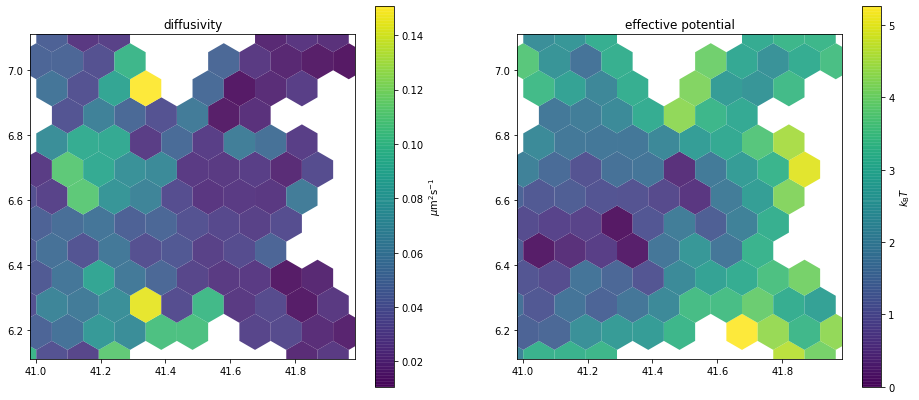

In [61]:
_, ax                             = plt.subplots(1, 2, figsize=(16,7))
a.mapper.mpl.plot(inferred_parameters, feature='diffusivity', sampling=data_sampling, title='diffusivity',         unit='std', axes=ax[0])
a.mapper.mpl.plot(inferred_parameters, feature='potential',   sampling=data_sampling, title='effective potential', unit='std', axes=ax[1])

First, as the data sampling has a direct impact on the appearance of the inferred parameter maps, let us detail again this step:

* first, due to `min_location_count=1`, the bins with less than one data point were excluded from the analysis (and not drawn);
* second, due to `from_nearest_neighbors(10)`, the bins with less than 10 data points were extended to include nearest neighbors of the bin center so that 10 data points were eventually assigned to the bin; note that the resulting bin overlap cannot be directed appreciated on the figures.

Second, the DV model was given two so-called *prior* parameters. These hyperparameters act as regularizing or smoothing parameters. They are trade-off parameters and each parameter weights a penalizing term like -- for example for diffusivity $D$:

$\sum_i\frac{A_i}{|N_i|}\sum_{j \in N_i}\frac{(D_i-D_j)^2}{||\textbf{r}_i-\textbf{r}_j||^2}$ with $N_i$ the neighbor bins of bin $i$, and $A_i$ the area of bin $i$.

These penalizing terms can be viewed as improper priors, *i.e.* priors that are not normalized. The task of normalizing these priors is left to the user, if she so wishes.

TRamWAy favors such not-normalized priors because they are more suitable for regularizing several data sets the same way. However, the hyperparameter selection is made a more difficult task and, for now, no reference search procedures are provided. This all depends on a trade-off between outlier removal and the expected scale for the optimal caracterization of the biological processes of interest.

## Custom mappers

The `mapper` attribute of an RWAnalyzer can be supplied with a custom function instead.
Such a function must take a [FiniteElements](https://tramway.readthedocs.io/en/latest/tramway.inference.html#tramway.inference.base.FiniteElements) object that basically operates like a dict of [Translocations](https://tramway.readthedocs.io/en/latest/tramway.inference.html#tramway.inference.base.Translocations) objects (for translocation data).
These latter objects feature data attributes such as `dr` for the assigned translocations/displacements, `dt` for the corresponding time steps (usually all equal to the frame interval) and `n` for the corresponding trajectory indices.

Below is a very basic example that counts the number of translocations assigned to each bin:

In [62]:
import numpy  as np
import pandas as pd

def translocation_count(microdomains):
    index, value = [], []
    for i in microdomains:
        index.append(i)
        value.append(len(microdomains[i].dr))
    return pd.DataFrame({'n': pd.Series(value, index)})

Again, define the processing steps:

In [63]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02

a.tesseller                       = tessellers.Hexagons

a.sampler.from_nearest_neighbors(10)
a.sampler.min_location_count      = 1

In [64]:
a.mapper.from_callable(translocation_count)

...and run them:

In [65]:
# step 1. read the data
translocation_data                = a.spt_data.dataframe
# step 2. sample the data
data_sampling                     = a.sampler.sample(translocation_data)
# step 3. extract the desired local estimates
maps                              = a.mapper.infer(data_sampling)
# step 4. print
n                                 = maps['n']
n

n
0     10
1     61
2     10
3     10
9     10
..   ...
140  238
141   44
146   10
147   16
148   10

[114 rows x 1 columns]

The excluded bins do not appear in the resulting dataframe. Building a dataframe with all the bins represented, and a default value for the excluded bins, should be performed as a post-processing step:

In [66]:
n_full                           = pd.DataFrame(
                                        # 0 as default value
                                        np.zeros(shape=(data_sampling.number_of_cells, 1), dtype=int),
                                        columns=n.columns,
                                        )
n_full.at[n.index]               = n
n_full

n
0    10
1    61
2    10
3    10
4     0
..   ..
145   0
146  10
147  16
148  10
149   0

[150 rows x 1 columns]

### Simplified output

Instead of explicitly returning a DataFrame, a mapper can also set additional attributes of the microdomain object:

In [67]:
def translocation_count(microdomains):
    for i in microdomains:
        microdomain               = microdomains[i]
        microdomain.n             = len(microdomain.dr)

However this requires the output attribute to be explicitly defined,
so that the values are collected and returned as a `Maps` object.

In [68]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.mapper.from_callable(translocation_count, returns=['n'])

To a lesser extent, this is also intended to prevent overwriting reserved attributes or mistyping attribute names, which may lead to errors difficult to debug.

*n* is actually an existing attribute name, hence the following `filterwarnings` statement to let the attribute be overwritten:

In [69]:
import warnings
warnings.filterwarnings('default', category=SideEffectWarning)

In [70]:
a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02

a.tesseller                       = tessellers.Hexagons

a.sampler.from_nearest_neighbors(10)
a.sampler.min_location_count      = 1

# step 1. read the data
translocation_data                = a.spt_data.dataframe
# step 2. sample the data
data_sampling                     = a.sampler.sample(translocation_data)
# step 3. extract the desired local estimates
maps                              = a.mapper.infer(data_sampling)
# step 4. print
maps['n']

/home/flaurent/github/TRamWAy/tramway/helper/inference.py:186: SideEffectWarning: output feature name is also an existing attribute: ['n']
  warn('output feature name is also an existing attribute: {}'.format(list(conflicting_names)), SideEffectWarning)


n
0     10
1     61
2     10
3     10
9     10
..   ...
140  238
141   44
146   10
147   16
148   10

[114 rows x 1 columns]

## Analyzing trajectories

The binning/sampling does not preserve the trajectories, since the displacements are individualized and assigned to possibly different bins.

As showed in [another notebook](test_single_traj.ipynb), an approach consists of making the full dataframe accessible in the function namespace, and retrieving the trajectory using the indices in the `n` attribute:

In [71]:
import numpy  as np
import pandas as pd

def mean_trajectory_feature(trajectory_data, feature, feature_name='my feature'):
    
    def infer(microdomains):
        index, value           = [], []
        for i in microdomains:

            trajectory_indices = np.unique( microdomains[i].n )

            local_estimates    = []
            for j in trajectory_indices:

                # trajectory_data is accessible from within the function
                trajectory     = trajectory_data[ trajectory_data['n'] == j ]

                # do something with the `trajectory` dataframe
                local_estimate = feature(trajectory)

                if not (local_estimate is None or np.isnan(local_estimate) or np.isinf(local_estimate)):
                    local_estimates.append(local_estimate)

            if local_estimates:
                mean_estimate  = np.mean(local_estimates)

                index.append(i)
                value.append(mean_estimate)

        return pd.DataFrame({feature_name: pd.Series(value, index)})
    
    return infer

In [72]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02

a.tesseller                       = tessellers.Hexagons

a.sampler.from_nearest_neighbors(10)
a.sampler.min_location_count      = 1

In [73]:
# step 1. is performed before defining the mapper function
translocation_data                = a.spt_data.dataframe

These demo data are [translocations and not trajectories](#Locations,-trajectories-and-translocations); convert:

In [74]:
from tramway.core import translocations_to_trajectories

trajectory_data                   = translocations_to_trajectories(translocation_data)

In [75]:
# (very) simple example: let us estimate the mean length of the trajectories that cross the bin
my_function                       = mean_trajectory_feature(trajectory_data, len, 'mean trajectory length')

a.mapper.from_callable(my_function)

In [76]:
# step 2. sample the data
data_sampling                     = a.sampler.sample(trajectory_data)
# step 3. extract the desired local estimates
maps                              = a.mapper.infer(data_sampling)
# step 4. print
maps['mean trajectory length']

mean trajectory length
4                  6.000000
11                 3.666667
12                 3.000000
17                 6.272727
18                 7.647059
..                      ...
153                2.333333
154               10.000000
155                9.200000
159                6.400000
160               10.666667

[87 rows x 1 columns]

### Early access to trajectories in ROI

Accessing the trajectories in a ROI before using the `mapper` attribute may be a bit tricky, especially if one wants to access the full trajectories and not only the part(s) within the ROI.

The only access to the data for a ROI (or support region) is the `crop` method.
Cropping trajectories removes the out-of-bound locations and splits the affected trajectories.
As a consequence, the trajectory index (column `n`) for cropped trajectories may NOT match the index of the original trajectories.

The following notebook cell shows how to retrieve the cropped trajectories and the corresponding original full trajectories:

In [77]:
from tramway.core.xyt import *

for f in a.spt_data:
    # as already mentioned, the `dataframe` attribute may represent either trajectory points (most common case) or translocations;
    # as from above, the data rows in the input file represents translocations and not all the trajectory points (the last location of each trajectory is omitted)
    all_translocations         = f.dataframe
    all_trajectories           = translocations_to_trajectories(translocation_data)
    
    for r in f.roi.as_individual_roi(): # here, `as_support_regions` can also be used instead of `as_individual_roi`
        cropped_translocations = r.crop().sort_values(by=['n','t'])
        cropped_trajectories   = translocations_to_trajectories(cropped_translocations)
        
        # use case 1: iterate the cropped trajectories (some trajectories may result from a same original trajectory)
        for cropped_trajectory in iter_trajectories(cropped_trajectories):
            pass
        
        # use case 2: iterate the original trajectories that - at least in part - lived in the region of interest
        for full_trajectory in iter_full_trajectories(cropped_translocations, all_trajectories):
            pass
        
        # use case 3: iterate the cropped trajectories and retrieve the corresponding full trajectory (that may appear multiple times)
        for cropped_trajectory, full_trajectory in zip(
                iter_trajectories(cropped_trajectories),
                iter_full_trajectories(cropped_translocations, all_trajectories, unique=False),
                ):
            pass

## *Embarrassingly parallel* mapper functions

On operating systems other than Windows, the low level mechanics of `infer` readily features some degree of parallelism for *embarrassingly parallel* computations such as previous examples `translocation_count` and `my_function`. If the core calculation of the function can be applied to each microdomain independently, instead of iterating the microdomains, `mapper` can be set to call the function for each bin.

The function should still iterate the bins. `infer` will actually build as many single-element `FiniteElements` objects as valid bins, and combine the output single-row (or empty) dataframes:

In [78]:
import numpy  as np
import pandas as pd

# here is (again) our most embarrassing function:
def translocation_count(microdomains):
    index, value = [], []
    for i in microdomains:
        index.append(i)
        value.append(len(microdomains[i]))
    return pd.DataFrame({'n': pd.Series(value, index)})

In [79]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02

a.tesseller                       = tessellers.Hexagons

a.sampler.from_nearest_neighbors(10)
a.sampler.min_location_count      = 1

In [80]:
a.mapper.from_callable(translocation_count)
a.mapper.cell_sampling            = 'individual'  # <- here is the main difference!

In [81]:
# step 1. read the data
translocation_data                = a.spt_data.dataframe
# step 2. sample the data
data_sampling                     = a.sampler.sample(translocation_data)
# step 3. extract the desired local estimates
parallel_maps                     = a.mapper.infer(data_sampling) # on Windows, this hangs and can be stopped restarting the notebook

# compare
parallel_n                        = parallel_maps['n']
assert np.all( parallel_n.index  == n.index  )
assert np.all( parallel_n.values == n.values )

Of course, parallelizing the example function is counterproductive due to the overhead of running multiple interpreters. Parallizing is desirable for computer-intensive atomic computations only.

Another limitation of this mechanics is that the spawned parallel processes run on the local host and cannot be dispatched as jobs to different nodes of a computer cluster, for example.

The RWAnalyzer introduces an additional layer for defining and running a pipeline either locally or remotely. However, such pipelines also suffer from some limitations and require a [dedicated notebook](RWAnalyzer%20simple%20pipeline.ipynb).

# Post-analysis

## Grouped ROI

\[to be continued\]